## Solving MNIST Digit Classification using Tensorflow 2.0
The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems. More about this dataset can be read on [wikipedia.](https://en.wikipedia.org/wiki/MNIST_database)
<img src="./MnistExamples.png">

In [1]:
import heapq
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

from tensorflow.keras.datasets import mnist

%matplotlib inline

In [2]:
import sys
from matplotlib import __version__  as mplt_v
print('seaborn version', sns.__version__)
print('tensorflow version', tf.__version__)
print('numpy version', np.__version__)
print('matplotlib version', mplt_v)
print('pandas version', pd.__version__)
print('system info (python version)', sys.version)

seaborn version 0.9.0
tensorflow version 2.0.0
numpy version 1.17.4
matplotlib version 3.0.3
pandas version 0.24.2
system info (python version) 3.5.2 (default, Oct  8 2019, 13:06:37) 
[GCC 5.4.0 20160609]


In [3]:
class NeuralNetwork:
    """
    This class contains the code for creating neural network and prunining it.
    """

    def __init__(self, prune_percent, prune_type):
        """
        Init function to initialising the instance of NeuralNetwork.

        :param int prune_percent: percentage of neurons we want to prune in each pass
        :param str prune_type: type of pruning to use, i.e., neuron or weight
        """
        self.prune_percent = prune_percent
        self.prune_type = prune_type

        # dataset related constants
        self.total_classes = 10  # total digits 0-9
        self.total_features = 28 * 28  # size of an image is 28x28

        # training related constants
        self.training_steps = 200
        self.batch_size = 300

        # neural network layers
        self.hidden_layers = (1000, 1000, 500, 200)
        self.get_data()
        self.initalise_layers_randomly()

        # Stochastic gradient descent optimizer
        learning_rate = 0.001
        self.optimizer = tf.optimizers.SGD(learning_rate)

    def get_data(self):
        """
        This function loads the MNIST dataset
        """
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
        x_train, x_test = x_train.astype(np.float32), x_test.astype(np.float32)

        # reshape the input data
        x_train = x_train.reshape([-1, self.total_features])
        x_test = x_test.reshape([-1, self.total_features])

        # normalize data
        self.x_train = x_train / 255.
        self.x_test = x_test / 255.
        self.y_train = y_train
        self.y_test = y_test

    def initalise_layers_randomly(self):
        """
        This function initialise the netural network with random weights.
        ALSO prunes the columns.

        Initialising the weights of a neural network `randomly` is important
        because noo matter what was the input - if all weights are the same,
        all units in hidden layer will be the same too.
        """
        random = tf.initializers.RandomNormal()
        self.weights = {
            'l1': tf.Variable(random(
                [self.total_features, self.hidden_layers[0]]
            )),
            'l2': tf.Variable(random(
                [self.hidden_layers[0], self.hidden_layers[1]]
            )),
            'l3': tf.Variable(random(
                [self.hidden_layers[1], self.hidden_layers[2]]
            )),
            'l4': tf.Variable(random(
                [self.hidden_layers[2], self.hidden_layers[3]]
            )),
            'out': tf.Variable(random(
                [self.hidden_layers[3], self.total_classes]
            ))
        }

        self.biases = {
            'b1': tf.Variable(tf.zeros([self.hidden_layers[0]])),
            'b2': tf.Variable(tf.zeros([self.hidden_layers[1]])),
            'b3': tf.Variable(tf.zeros([self.hidden_layers[2]])),
            'b4': tf.Variable(tf.zeros([self.hidden_layers[3]])),
            'out': tf.Variable(tf.zeros([self.total_classes])),
        }

    @staticmethod
    def neuron_prune(w, p):
        """
        Function for pruning the weights as per L2 norm of each column.

        :param tensor w: tensor of weights
        :param int p: percentage of weights to prune
        """
        # find L2 norm column wise
        w = w.numpy()
        l2 = np.linalg.norm(w, axis=0)
        # find number of columns to prune aways
        cols_to_prune = int(w.shape[1] * p / 100)
        sorted_cols = np.argsort(l2)
        for i in range(cols_to_prune):
            col = sorted_cols[i]
            w[:, col] = 0.
        return tf.Variable(w)

    @staticmethod
    def weight_prune(w, p):
        """
        Function for pruning the weights based on their absolute values.

        :param tensor w: tensor of weights
        :param int p: percentage of weights to prune
        """
        w = w.numpy()
        rows, cols = w.shape
        total_neurons = rows*cols
        neurons_to_prune = int(total_neurons * p / 100)
        # cache absolute value of each weight
        heap = []
        for r in range(rows):
            for c in range(cols):
                val = abs(w[r][c])
                heap.append((val, r, c))
        # heapify the whole thing
        heapq.heapify(heap)
        # prune k% of weights
        for each in heapq.nsmallest(neurons_to_prune, heap):
            _, r, c = each
            w[r][c] = 0.
        return tf.Variable(w)

    def prune_weights(self):
        """
        Function for pruning the weight matrix as per the L2 norm
        of each column.
        NOTE: % of columns to be pruned is given as argument when
        initialising the class.
        """
        if self.prune_type == 'neuron':
            prune_func = NeuralNetwork.neuron_prune
        elif self.prune_type == 'weight':
            prune_func = NeuralNetwork.weight_prune
        else:
            raise ValueError('given prune type not supported %s' % self.prune_type)
        for layer in ('l1', 'l2', 'l3', 'l4'):
            self.weights[layer] = prune_func(
                w=self.weights[layer], p=self.prune_percent
            )

    def forward_pass(self, inp):
        """
        Function for making a forward pass in the neural network.

        :param tensor inp: input matrix of images with shape -> (batch size, features)
        """
        # prune weights
        self.prune_weights()

        # first layer
        layer_1 = tf.add(tf.matmul(inp, self.weights['l1']), self.biases['b1'])
        layer_1 = tf.nn.relu(layer_1)

        # second layer
        layer_2 = tf.add(tf.matmul(layer_1, self.weights['l2']), self.biases['b2'])
        layer_2 = tf.nn.relu(layer_2)

        # third layer
        layer_3 = tf.add(tf.matmul(layer_2, self.weights['l3']), self.biases['b3'])
        layer_3 = tf.nn.relu(layer_3)

        # fourth layer
        layer_4 = tf.add(tf.matmul(layer_3, self.weights['l4']), self.biases['b4'])
        layer_4 = tf.nn.relu(layer_4)

        # output layer
        out_layer = tf.add(tf.matmul(layer_4, self.weights['out']), self.biases['out'])
        return tf.nn.softmax(out_layer)

    def update_weights(self, w, y):
        """
        Function for making a forward and backward pass in the neural network,
        after which weights gets updated.

        :param tensor w: weight matrix tensor
        :param tensor y: label
        """
        # Gradient Tape is used to train and/or compute gradients in eager execution
        with tf.GradientTape() as g:
            pred = self.forward_pass(w)
            loss = self.cross_entropy_loss(pred, y)

        # get weights to be updated
        weights_to_update = list(self.weights.values()) + list(self.biases.values())

        # calculalte gradients
        gradients = g.gradient(loss, weights_to_update)

        # update weights and biases
        self.optimizer.apply_gradients(zip(gradients, weights_to_update))

    def cross_entropy_loss(self, y_pred, y_true):
        """
        Function for calculating cross entropy loss after one forward pass.
        Cross entropy loss function takes two distribution, true and estimated.

        :param tensor y_pred: tensor of predicted values
        :param tensor y_true: tensor of true values
        """
        # one hot encoding of the true 'y'
        y_true = tf.one_hot(y_true, depth=self.total_classes)

        # log(0) will throw and error, so to avoid that we clip the each value
        y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

        # mean( -1 * sum [ log(y_pred)*y_true ] )
        return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

    @staticmethod
    def accuracy(y_pred, y_true):
        """
        Function to find the accuracy of predictions

        :param tensor y_pred: tensor of predictions
        :param tensor y_true: tensor of true values
        """
        y_true = tf.cast(y_true, tf.int64)
        y_pred = tf.argmax(y_pred, axis=1)
        correct_prediction = tf.equal(y_pred, y_true)
        correct_prediction = tf.cast(correct_prediction, tf.float32)
        return tf.reduce_mean(correct_prediction)

    def train(self):
        """
        Main function to training the neural network
        """
        # shuffle and split data into batches
        train_data = tf.data.Dataset.from_tensor_slices((self.x_train, self.y_train))
        train_data = train_data.repeat().shuffle(1000).batch(self.batch_size).prefetch(1)

        accuracy_cache = list()
        loss_cache = list()
        for i, (x_b, y_b) in enumerate(train_data.take(self.training_steps)):
            # Run the optimization to update W and b values.
            self.update_weights(x_b, y_b)

            if (i + 1) % 20 == 0:
                pred = self.forward_pass(x_b)
                loss = self.cross_entropy_loss(pred, y_b)
                acc = self.accuracy(pred, y_b)
#                 print("step= %i, loss= %f, acc= %f" % (i + 1, loss, acc))
                accuracy_cache.append([self.prune_percent, i+1, acc.numpy()])
                loss_cache.append([self.prune_percent, i+1, loss.numpy()])
        test_acc = self.test_accuracy()
#         print("test accuracy = %f" % test_acc)
        return accuracy_cache, loss_cache, test_acc

    def test_accuracy(self):
        """
        Function to find the accuracy on test data
        """
        test_acc = self.accuracy(self.forward_pass(self.x_test), self.y_test)
        return test_acc.numpy()

# NEURON BASED PRUNING RESULTS

In [4]:
from concurrent.futures import ProcessPoolExecutor
from itertools import repeat
from multiprocessing import cpu_count


def parallel_training(prune_percent, prune_type):
    """
    Function to parallelize the training.
    
    :param int prune_percent: percentage of weights to prune
    :param str prune_type: prune method, neuron or weight
    
    :returns: train accuracy, train loss and test accuracy
    """
    ob = NeuralNetwork(prune_percent, prune_type)
    accuracy_cache, loss_cache, test_acc = ob.train()
    del ob
    return accuracy_cache, loss_cache, [prune_percent, test_acc]

In [5]:
acc_results = list()
loss_results = list()
test_acc_results = list()

pruning = [0, 25, 50, 60, 70, 80, 90, 95, 97, 99]
with ProcessPoolExecutor(max_workers=cpu_count()) as exe:
    for acc, loss, test_acc in exe.map(parallel_training, pruning, repeat('neuron')):    
        acc_results.extend(acc)
        loss_results.extend(loss)
        test_acc_results.append(test_acc)


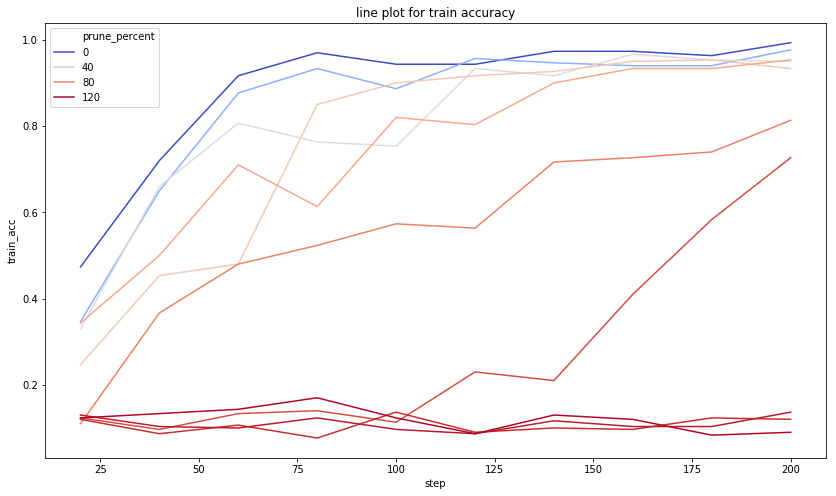

In [6]:
acc_results_df = pd.DataFrame(acc_results, columns=['prune_percent', 'step', 'train_acc'])
acc_results_df.sort_values(['step'], inplace=True)

plt.figure(figsize=(14, 8))
sns.lineplot(data=acc_results_df, x='step', y='train_acc', hue='prune_percent', palette='coolwarm')
plt.title('line plot for train accuracy')
plt.show()

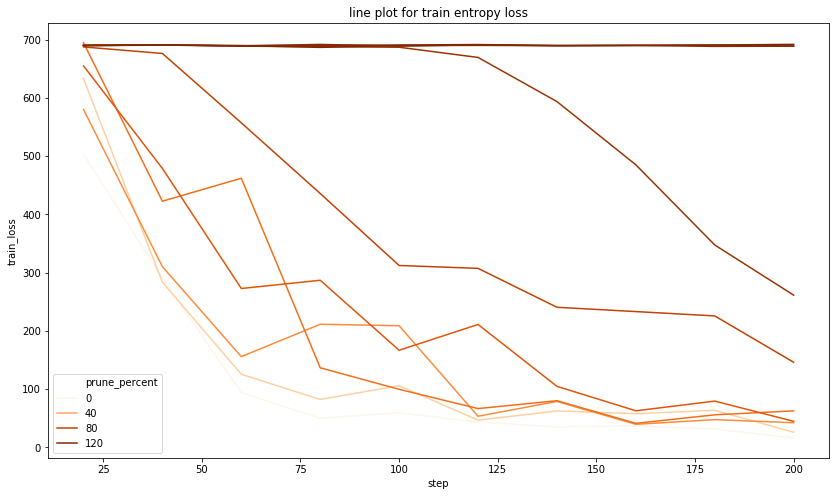

In [7]:
loss_results_df = pd.DataFrame(loss_results, columns=['prune_percent', 'step', 'train_loss'])
loss_results_df.sort_values(['step'], inplace=True)

plt.figure(figsize=(14, 8))
sns.lineplot(data=loss_results_df, x='step', y='train_loss', hue='prune_percent', palette='Oranges')
plt.title('line plot for train entropy loss')
plt.show()

Text(0.5, 1.0, 'comparison of test accuracy for different prunings')

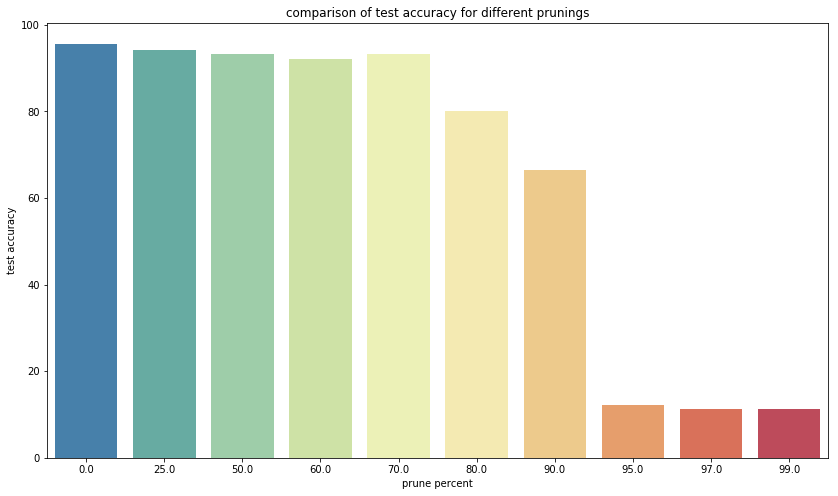

In [9]:
plt.figure(figsize=(14, 8))

tem = np.array(test_acc_results)
sns.barplot(x=tem[:, 0], y=tem[:, 1]*100, palette='Spectral_r')
plt.xlabel('prune percent')
plt.ylabel('test accuracy')
plt.title('comparison of test accuracy for different prunings')

# WEIGHT BASED PRUNING RESULTS

In [10]:
acc_results = list()
loss_results = list()
test_acc_results = list()

pruning = [0, 25, 50, 60, 70, 80, 90, 95, 97, 99]
with ProcessPoolExecutor(max_workers=cpu_count()) as exe:
    for acc, loss, test_acc in exe.map(parallel_training, pruning, repeat('weight')):    
        acc_results.extend(acc)
        loss_results.extend(loss)
        test_acc_results.append(test_acc)


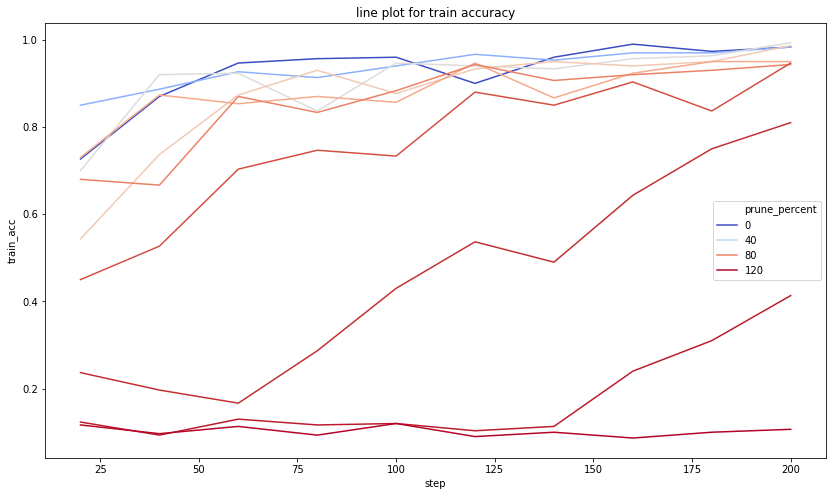

In [11]:
acc_results_df = pd.DataFrame(acc_results, columns=['prune_percent', 'step', 'train_acc'])
acc_results_df.sort_values(['step'], inplace=True)

plt.figure(figsize=(14, 8))
sns.lineplot(data=acc_results_df, x='step', y='train_acc', hue='prune_percent', palette='coolwarm')
plt.title('line plot for train accuracy')
plt.show()

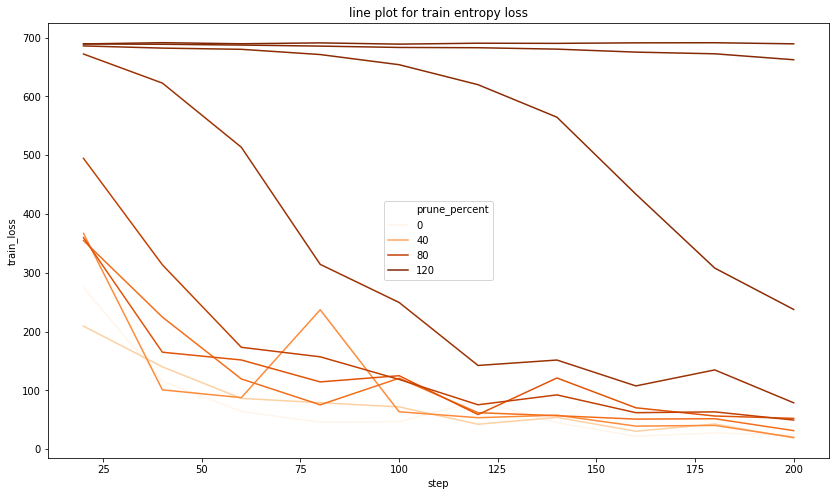

In [12]:
loss_results_df = pd.DataFrame(loss_results, columns=['prune_percent', 'step', 'train_loss'])
loss_results_df.sort_values(['step'], inplace=True)

plt.figure(figsize=(14, 8))
sns.lineplot(data=loss_results_df, x='step', y='train_loss', hue='prune_percent', palette='Oranges')
plt.title('line plot for train entropy loss')
plt.show()

Text(0.5, 1.0, 'comparison of test accuracy for different prunings')

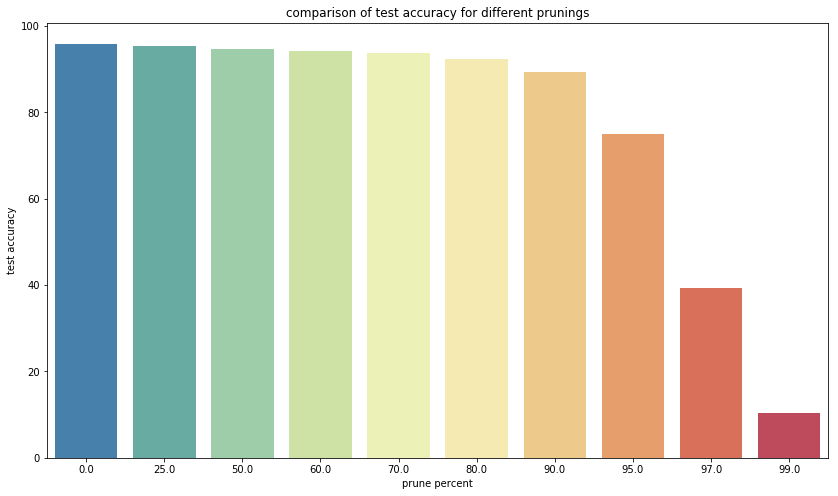

In [13]:
plt.figure(figsize=(14, 8))

tem = np.array(test_acc_results)
sns.barplot(x=tem[:, 0], y=tem[:, 1]*100, palette='Spectral_r')
plt.xlabel('prune percent')
plt.ylabel('test accuracy')
plt.title('comparison of test accuracy for different prunings')